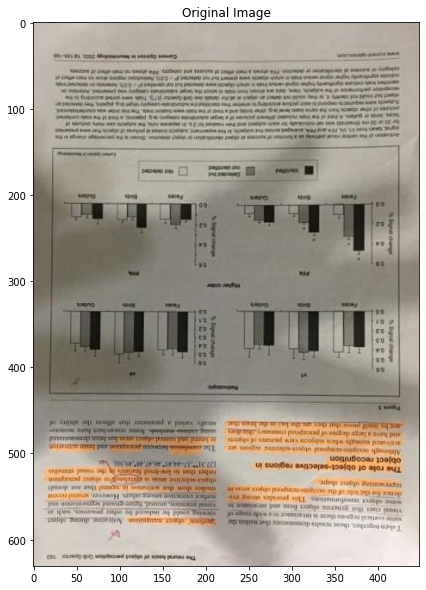

In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import color,filters
from scipy import ndimage as ndi
from helper_functions import *


base_img_rpath = '../dataset/document/'
base_img_wpath = '../output/document/'

#choices = 'color_mosaic.jpg', 'textbook.jpg', 'manuscript.jpg'
filename = 'rect_16.jpg'
doc = Image.open(base_img_rpath + filename)



doc_shad = np.array(doc)
doc_orig = np.array(doc)
shd_ratio = 0.35

plt.figure(figsize = (8,10))
plt.imshow(doc)
plt.title('Original Image')
plt.show()

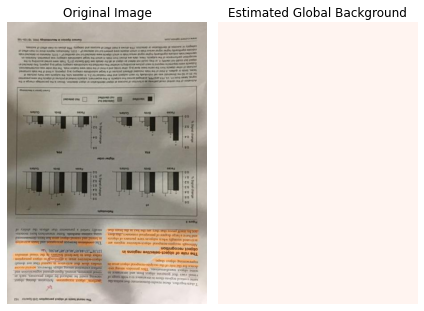

In [6]:
choice = 3
title1 = 'Original Image'
title2 = 'Estimated Global Background'

if choice==1:

  # Global average over each channel  (Approach #1)  
  global_col = doc_orig.copy()
  global_col[:,:,0], global_col[:,:,1], global_col[:,:,2] = np.average(doc_orig, axis=(0,1))
  show_img_compar(doc_orig, global_col, title1, title2)
elif choice==2:

  # Max pixel value for each channel   (Approach #2)
  img_temp = doc_orig.copy()
  # By counting most frequent pixels
  #unique, counts = np.unique(doc_orig.reshape(-1, 3), axis=0, return_counts=True)
  #img_temp[:,:,0], img_temp[:,:,1], img_temp[:,:,2] = unique[np.argmax(counts)]
  img_temp[:,:,0] = np.ones((doc_orig.shape[0],doc_orig.shape[1])) * np.max(doc_orig[:,:,0])
  img_temp[:,:,1] = np.ones((doc_orig.shape[0],doc_orig.shape[1])) * np.max(doc_orig[:,:,1])
  img_temp[:,:,2] = np.ones((doc_orig.shape[0],doc_orig.shape[1])) * np.max(doc_orig[:,:,2])
  show_img_compar(doc_orig, img_temp, title1, title2)
elif choice==3:

  # Average of top 50 pixels   (Approach #3)
  I_global = doc_orig.copy()

  dom_r = np.partition(doc_orig[:,:,0].flatten(), -2)[-50:]
  mean_val_r = np.mean(dom_r)

  dom_g = np.partition(doc_orig[:,:,1].flatten(), -2)[-50:]
  mean_val_g = np.mean(dom_g)

  dom_b = np.partition(doc_orig[:,:,2].flatten(), -2)[-50:]
  mean_val_b = np.mean(dom_b)

  I_global[:,:,0] = np.ones((doc_orig.shape[0],doc_orig.shape[1])) * mean_val_r
  I_global[:,:,1] = np.ones((doc_orig.shape[0],doc_orig.shape[1])) * mean_val_g
  I_global[:,:,2] = np.ones((doc_orig.shape[0],doc_orig.shape[1])) * mean_val_b
  show_img_compar(doc_orig[:,:,:], I_global, title1, title2)


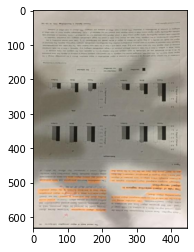

In [7]:
# Preliminary Estimation

p = 0.7  #p-percentile
block_size = 3  #block size

m = doc_orig.shape[0]
n = doc_orig.shape[1]

I_local = np.zeros((m,n,3))
for c_ch in range(3):
    #block_intensities = np.array([])
    for i in range(m):
        for j in range(n):
            block_intensities = np.array([])
            if i > 0 and i < m-1 and j > 0 and j < n-1:
                #print('here')
                block_intensities = np.append(block_intensities,(doc_orig[i+1][j][c_ch],doc_orig[i-1][j][c_ch],doc_orig[i][j-1][c_ch],doc_orig[i][j+1][c_ch]))
                block_intensities = np.append(block_intensities, (doc_orig[i-1][j-1][c_ch],doc_orig[i-1][j+1][c_ch],doc_orig[i+1][j+1][c_ch],doc_orig[i+1][j-1][c_ch]))
            if i==0:
                if j==0:
                    block_intensities = np.append(block_intensities, (doc_orig[i][j+1][c_ch],doc_orig[i+1][j+1][c_ch],doc_orig[i+1][j][c_ch]))
                elif j==n-1:
                    block_intensities = np.append(block_intensities, (doc_orig[i][j-1][c_ch],doc_orig[i+1][j-1][c_ch],doc_orig[i+1][j][c_ch]))
                else:
                    block_intensities = np.append(block_intensities, (doc_orig[i][j+1][c_ch],doc_orig[i+1][j+1][c_ch],doc_orig[i+1][j][c_ch],doc_orig[i+1][j-1][c_ch],doc_orig[i][j-1][c_ch]))
            if i==n-1:
                if j==0:
                    block_intensities = np.append(block_intensities, (doc_orig[i][j+1][c_ch],doc_orig[i-1][j+1][c_ch],doc_orig[i-1][j][c_ch]))
                elif j==n-1:
                    block_intensities = np.append(block_intensities, (doc_orig[i][j-1][c_ch],doc_orig[i-1][j-1][c_ch],doc_orig[i-1][j][c_ch]))
                else:
                    block_intensities = np.append(block_intensities, (doc_orig[i][j+1][c_ch],doc_orig[i-1][j+1][c_ch],doc_orig[i-1][j][c_ch],doc_orig[i-1][j-1][c_ch],doc_orig[i][j-1][c_ch]))
            
            if j==0:
              if i!=0 and i!=m-1:
                block_intensities = np.append(block_intensities, (doc_orig[i][j+1][c_ch], doc_orig[i-1][j+1][c_ch], doc_orig[i-1][j][c_ch],doc_orig[i+1][j+1][c_ch],doc_orig[i+1][j][c_ch]))
            if j==n-1:
              if i!=0 and i !=m-1:
                block_intensities = np.append(block_intensities, (doc_orig[i][j-1][c_ch], doc_orig[i-1][j-1][c_ch], doc_orig[i-1][j][c_ch],doc_orig[i+1][j-1][c_ch],doc_orig[i+1][j][c_ch]))


            if block_intensities.size !=0:
                I_local[i][j][c_ch] = np.percentile(block_intensities,80, axis=0)
                if I_local[i][j][c_ch] > 255:
                    I_local[i][j][c_ch] = 255
                
                if I_local[i][j][c_ch] < 0:
                    I_local[i][j][c_ch] = 0

I_local = I_local.astype(int)
#I_local = np.copy(doc_orig)   
plt.imshow(I_local)
plt.show()


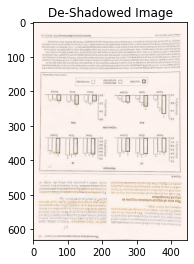

In [8]:
shadow_map = np.zeros(doc_orig.shape)
shadow_map = I_local / I_global

for k in range(3):
  for i in range(m):
    for j in range(n):
      if(shadow_map[i][j][k]==0):
        shadow_map[i][j][k] = 1


I_rest = doc_orig / shadow_map
I_rest = I_rest.astype(int)
I_rest = np.clip(I_rest,0,255)

plt.imshow(I_rest)
plt.title('De-Shadowed Image')
plt.savefig(base_img_wpath + filename)
